# Optimizing Spatial Queries with the Spatial Index in GeoPandas with Rtrees

In [1]:
import geopandas as gpd

# Filepaths
intersections_fp = "uusimaa_intersections.gpkg"
postcode_areas_fp = "uusimaa_postal_code_areas.gpkg"

intersections = gpd.read_file(intersections_fp)
postcode_areas = gpd.read_file(postcode_areas_fp)

# Check the data
print(intersections.head(), '\n-------')
print(postcode_areas.head())

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


            x            y                        geometry
0  330888.502  6675829.949  POINT (330888.502 6675829.949)
1  348059.990  6670041.685  POINT (348059.990 6670041.685)
2  348022.592  6670202.858  POINT (348022.592 6670202.858)
3  297208.220  6669048.357  POINT (297208.220 6669048.357)
4  330835.341  6675586.834  POINT (330835.341 6675586.834) 
-------
  posti_alue  he_vakiy                                           geometry
0      00100   18284.0  MULTIPOLYGON (((385653.893 6671591.048, 385573...
1      00120    7108.0  MULTIPOLYGON (((385316.092 6671076.984, 385279...
2      00130    1508.0  MULTIPOLYGON (((386212.111 6671061.262, 386176...
3      00140    7865.0  MULTIPOLYGON (((386577.050 6670280.544, 386552...
4      00150    9496.0  MULTIPOLYGON (((384846.102 6669565.816, 384823...


In [2]:
# Output number of intersections and post code areas
print("Number of intersections:", len(intersections))
print("Number of postal code areas:", len(postcode_areas))

Number of intersections: 63518
Number of postal code areas: 370


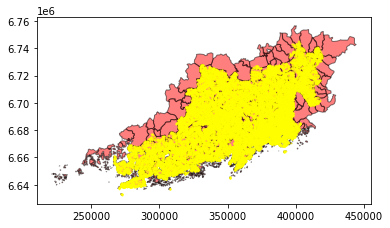

In [4]:
# Display how datasets look on a map
ax = postcode_areas.plot(color='red', edgecolor='black', alpha=0.5)
ax = intersections.plot(ax=ax, color='yellow', markersize=1, alpha=0.5)

(6667500.0, 6680000.0)

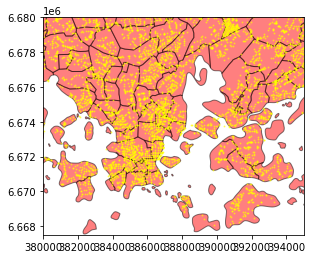

In [6]:
# Close-up of above map
ax = postcode_areas.plot(color='red', edgecolor='black', alpha=0.5)
ax = intersections.plot(ax=ax, color='yellow', markersize=1, alpha=0.5)

ax.set_xlim([380000, 395000])
ax.set_ylim([6667500, 6680000])

In [7]:
# Build a spatial index by calling an attribute .sindex
intersection_sindex = intersections.sindex

# Display SpatialIndex object
intersection_sindex

#### The SpatialIndex object contains the geometries in an R-tree data structure.

In [35]:
# How many groups (i.e. bounding boxes) do we have?
bounding_boxes = 0
for idx, row in postcode_areas['geometry'].items():
    bounding_boxes += len(intersection_sindex.intersection(row.bounds))
# postcode_areas.geometry.apply(lambda x: bounding_boxes.append(len(intersection_sindex.intersection(postcode_areas.geometry.bounds(x)))))
print("Number of groups:", bounding_boxes, '\n')

Number of groups: 119759 



The spatial index of the intersection can be used to compare the geometry of a given postal code area to the bounding boxes of points inside the R-tree spatial index. This allows a spatial query which selects all points inside this Polygon.

<AxesSubplot:>

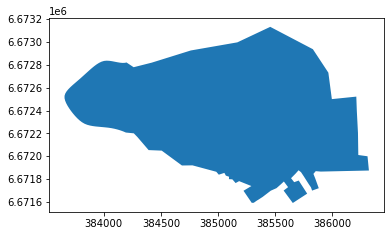

In [36]:
# Select a postal code area representing the city center of Helsinki
city_center_zip_area = postcode_areas.loc[postcode_areas['posti_alue']=='00100']
city_center_zip_area.plot()

Step #1: compare the bounds of the Polygon into the spatial index of the Points. This yields point candidates that are likely fall within the Polygon (at this stage based on the MBR of the points that are stored inside the R-tree).<br>
Step #2: go through the candidate points and make a spatial intersection query that gives the results:

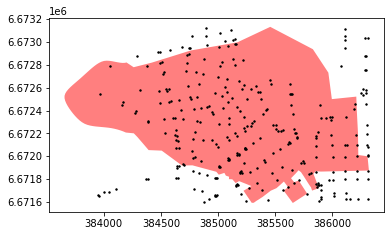

In [37]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(city_center_zip_area.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
point_candidate_idx = list(intersection_sindex.intersection(bounds))
point_candidates = intersections.loc[point_candidate_idx]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = point_candidates.plot(ax=ax, color='black', markersize=2)

#### Above graphic indicates successful selection of such points from the dataset that intersect with the bounding box of the Polygon.

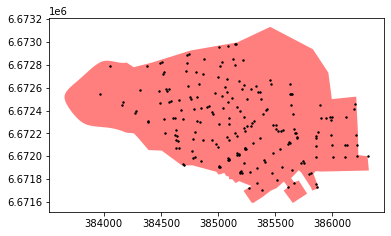

In [39]:
# Make the precise Point in Polygon query
final_selection = point_candidates.loc[point_candidates.intersects(city_center_zip_area['geometry'].values[0])]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = final_selection.plot(ax=ax, color='black', markersize=2)

# Performance comparisons

In [40]:
def intersect_using_spatial_index(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points
    intersect with ANY of those geometries.
    """
    source_sindex = source_gdf.sindex
    possible_matches_index = []

    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        bounds = other.geometry.bounds
        c = list(source_sindex.intersection(bounds))
        possible_matches_index += c

    # Get unique candidates
    unique_candidate_matches = list(set(possible_matches_index))
    possible_matches = source_gdf.iloc[unique_candidate_matches]

    # Conduct the actual intersect
    result = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]
    return result

def normal_intersect(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection without spatial index.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points
    intersect with ANY of those geometries.
    """

    matches = []

    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        c = list(source_gdf.loc[source_gdf.intersects(other.geometry)].index)
        matches += c

    # Get all points that are intersecting with the Polygons
    unique_matches = list(set(matches))
    result = source_gdf.loc[source_gdf.index.isin(unique_matches)]
    return result

In [41]:
# Test the spatial query with spatial index
%timeit intersect_using_spatial_index(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

39.8 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
# Test the spatial query without spatial index
%timeit normal_intersect(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

48.2 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Note**<br>
The spatial index can make spatial queries significantly faster. However, there are specific situations in which spatial indices do not yield improvements in performance. If the polygon and points have a more similar spatial extent (bounding box), the spatial index will not make queries faster due to design of the bounding boxes.

**References**
1) https://geoffboeing.com/2016/10/r-tree-spatial-index-python/ <br>
2) https://rtree.readthedocs.io/en/latest/tutorial.html